### Problem 4-23.

Unemployment rate data are given in Table B-8.

**(a)** Make a time series plot of the data.

**(b)** Use simple exponential smoothing with $\lambda = 0.2 $ to smooth the data.  
How well does this smoothing procedure work?  Do you think that simple exponential smoothing shuld be used to forecast this data?

### Import Excel data.

The original table B-8 had multiple date/rate pairs spread across rows,making it very difficult to import and process directly.  The table was reformmated so there are only two columns:

| Field | Description |
|:-|:-|
| Date  | Sample date in mm/dd/yyyy format |
| Rate  | Unemployment rate in percent     |


In [5]:
proc import out=Unemployment 
  datafile='Table B-8 MMDDYYYY Format.xlsx' 
  dbms=xlsx replace; 
  getnames=yes; datarow=2;
 run;

### Introduction to the data.
The data samples are monthly unemployment rates for the full time labor force, from Jan63 to Dec04.  This is a large dataset, there are over 500 samples.  They are obtained from the Bureau of Labor Statistics (https://data.bls.gov/cgi-bin/srgate

The unemployment rates are **not** seasonally adjusted.

The mean, min/max and variance for this data are shown below.  The highest unemployment rates are in 1982, when there was a recession (July 1981-November 1982).  Source: https://www.federalreservehistory.org/essays/recession_of_1982_82


In [29]:
proc means data=Unemployment
  n
  mean
  median
  min  max
  var std;
  
  var Rate;
run;

### Rate distribution
Use a histogram with a normal distribution curve to see the distribution of rate.  There is a bit of negative skew, which is realistic as unemployment rates are typically higher valued and rarely are zero or just above zero.


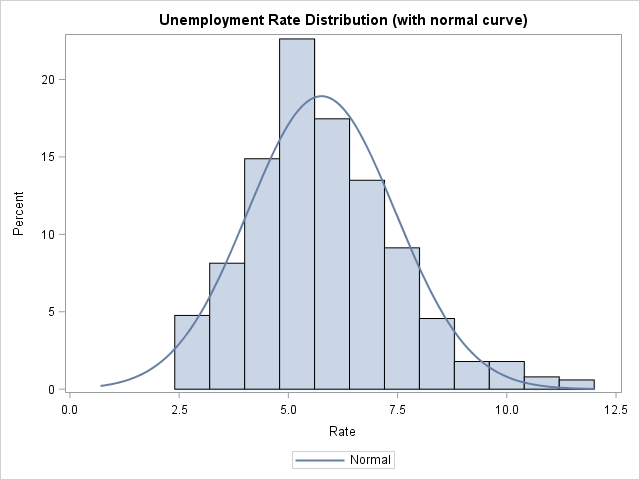

In [30]:
title "Unemployment Rate Distribution (with normal curve)";
proc sgplot data = Unemployment;
  histogram Rate;
  density Rate;
run;

### Part (a) - Time-Series plot

The plot shows that there appears to be some periodic cycles (about 5 or so) that cycle around differing unemployment rates.  This data does not appear to be stationary.

* In the 1960s the rate drops from 6% to 2%.
* In the 1970s the rate rises to a high of 9% and ends around 5%.
* In the 1980s the rate starts and ends at 5% but has a big peak of 12%.
* In the 1990s the starts at 5%, rises to 8% and ends around 3%.
* In the 2000s the rate starts at 3%, rises to 6% and then drops to about 5% in 2005.

The data has a lot of jaggy month-to-month variation.


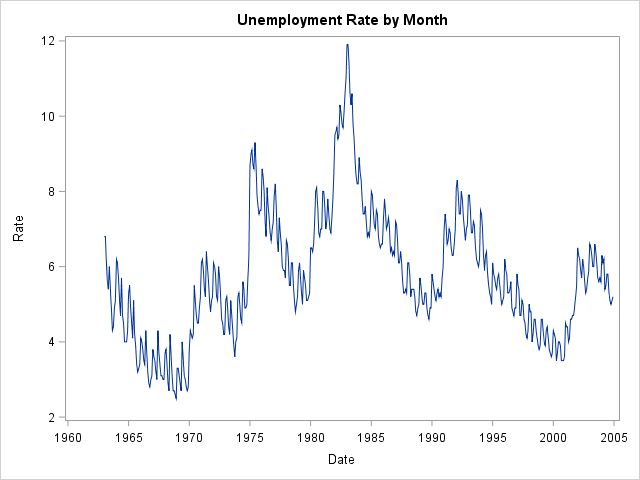

In [4]:
ods graphics on;
title "Unemployment Rate by Month";
proc sgplot data=Unemployment;
  series x=Date y=Rate;
  format date YEAR4.;
run;

### Part (b) - Exponential Smoothing

This problem states to use a $\lambda$ value of 0.2, and that means that we must use PROC FORECAST, because PROC ESM does not allow the user to specify a $\lambda$ value.  The default value of $\alpha$ for PROC FORECAST is 0.05, so we don't both specifying that.



In [31]:
title "Forecast with Exponential Smoothing";
proc forecast data=Unemployment
              method=expo
              weight=0.2
              interval=MONTH
              out=UnemploymentForecast outfull outresid outest=est;
  id Date;
  var Rate;
run;

### Forecast Results - Smoothing
Using the output data set *UnemploymentForecast*, produce a time-series plot of the smoothed data, adding a vertical reference line to demarcate the last 2 years of data.

The rate values do so some smoothing (less month to month variation), and the time-series is retaining its original shape, which is good, in that the cyclic variations have not been flattened.


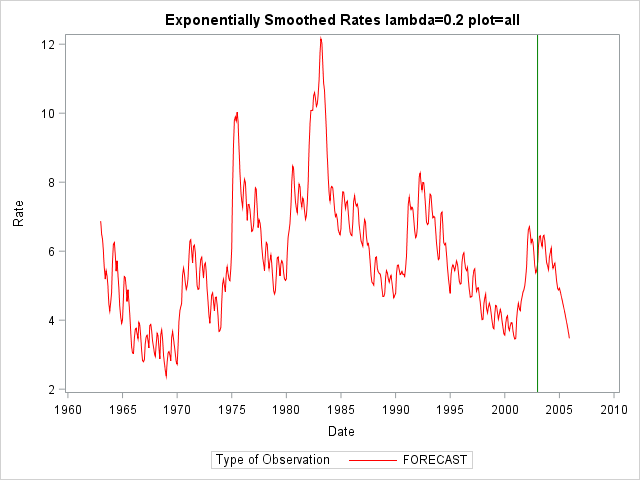

In [24]:
title "Exponentially Smoothed Rates lambda=0.2";
proc sgplot data=UnemploymentForecast;
  series x=Date y=Rate / group =_type_ lineattrs=(color=red);
  where _type_ = 'FORECAST';
  refline '1jan03'd / axis=x lineattrs=(color=green);
  format date YEAR4.;
run;

### Part (c) - Does Smoothing Produce a Good Forecast?

A graph is output to show the actual (Jan-02 through Dec-04) and forecast rates (Jan-02 through Dec-05), along with a 95% confidence interval for the forecast.  The previous decades of data are not shown, since we are now focused on how well the model is predicting (forecasting) the unemployment rate.  A vertical reference line is also added at the end of 2004 (which is the end of the actual data).

The results are mixed.  At the end of 2004, the actual data is showing an upward rising trend, while the forecast is trending downward.  The confidence interval starts with a wide range (about 3% for the first prediction period) and quickly expands, ending up at about 9% at LEAD 12.


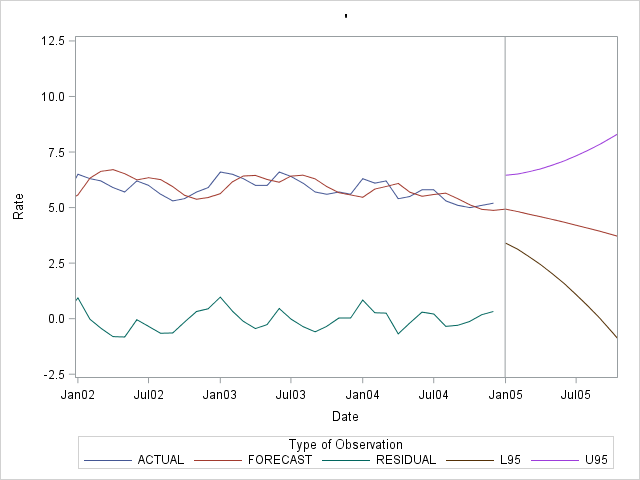

In [15]:
title "";
proc sgplot data=UnemploymentForecast;
  series x=Date y=Rate / group=_type_;
  xaxis values=('1jan02'd to '31dec05'd by qtr);
  refline '31dec04'd / axis=x;
  format date monyy5.;
run;

### CI Details
The previous graph shows the visual expansion of the confidence interval.  by taking a look at the actual values can produce a more quantatative view of the prediction CI.  This is done by selecting the CI values for the prediction period.

What's observed is the rapid loss of confidence:
* Lead 1 (Jan05) CI range = 3%
* Lead 2 (Feb05) CI range = 3.4%
* Lead 3 (Mar05) CI range = 3.8%
* Lead 4 (Apr05) CI range = 4.3%
* Lead 5 (May05) CI range = 4.9%
* Lead 12 (Dec05) CI range = 10.2%

Looking at the last 2 years of actual data (2003, 2004), the unemployment rate variation for 2003 is 1%, and for 2004 it is 1.2%.  So a prediction CI for the first few months of around 3% is reasonable, given the actual variation in the prevoius two years of data of about 1.2%.

If this model is used for short-term (one quarter out) forecasting, the performance is reasonable - the prediction CI is acceptable and the forecast unemployment rates are also acceptable.   The model should not be used for longer term forecasts, there is too much uncertainty and the confidence intervals start to exceed most of the actual unemployment rates for the last 30 years.

In [18]:
proc print data=UnemploymentForecast;
  var _LEAD_ _TYPE_ Rate;
  where Date >= '1Jan05'd and _TYPE_ ^= 'FORECAST';
run;

Obs,_LEAD_,_TYPE_,Rate
1514,1,L95,3.4048118431
1515,1,U95,6.453494203
1517,2,L95,3.1278297294
1518,2,U95,6.512586827
1520,3,L95,2.8032095168
1521,3,U95,6.6099737414
1523,4,L95,2.4334766384
1524,4,U95,6.7431295128
1526,5,L95,2.0214017895
1527,5,U95,6.9092834462


### Model Analysis
Looking at the estimation information provided in the *outest* dataset, the $R^2$ value is very high at over 87%.

In [27]:
proc print data=est;
run;

Obs,_TYPE_,Date,Rate
1,N,12/01/2004,504
2,NRESID,12/01/2004,504
3,DF,12/01/2004,501
4,WEIGHT,12/01/2004,0.2
5,S1,12/01/2004,5.3570791
6,S2,12/01/2004,5.6059819
7,S3,12/01/2004,5.7801343
8,SIGMA,12/01/2004,0.5858272
9,CONSTANT,12/01/2004,5.0334259
10,LINEAR,12/01/2004,-0.101937


### Auto-correlation Check.
Given the suspiciously high $R^2$ value, use PROC ESM to produce an auto-correlation plot.
Although PROC ESM will choose what it considers to be an optimal value of $\lambda$, seeing
if autocorrelation exists for the "best" $\lambda$ is quite useful.

The ACF output shows significant auto-correlation, which will require further cycles of model development.


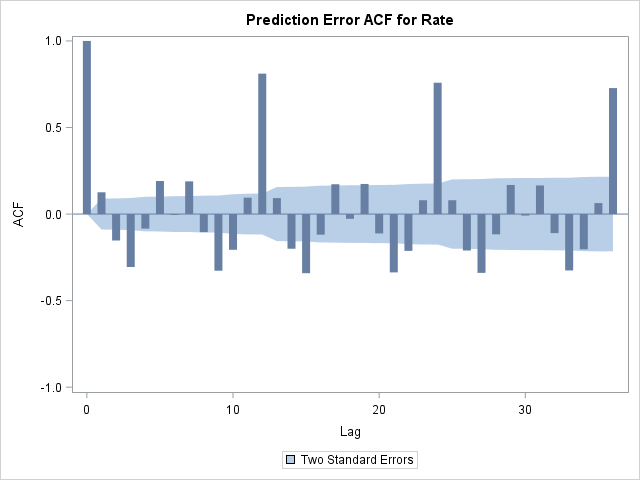
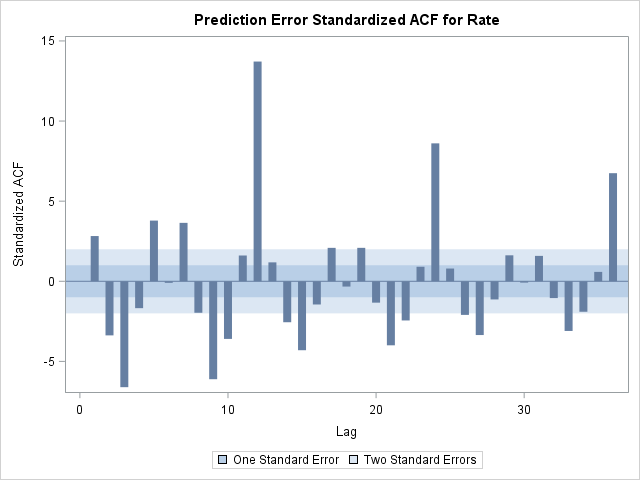

In [26]:

proc esm data=Unemployment plot=acf;
  id Date interval=month;
  forecast rate / model=simple;
run;

### Conclusion
The forecast model with a $\lambda$ value of 0.2 gives some reasonable predicitive power to a short term (less than a quarter) forecast.  

The data do exhibit significant auto-correlation.  This should be corrected before trusting the model for even short term forecasting.

Finally, the input data are not seasonally adjusted.  It's unclear what effect seasonal adjustment might have on an unemployment rate forecasting model.  But it is something that should be analyzed for future model development